In [48]:
import librosa
import os, gc
import numpy as np
import random
import itertools

from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import xgboost as xgb

import matplotlib.pyplot as plt

In [99]:
PROJECT_PATH='/home/hmenn/Workspace/CSE455_MachineLearning_2018/Final_MusicClassification'

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, figsize=(6,6)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [101]:
def extractMfccFeature(filepath, _offset=12, _duration=6):
    try:
        # returns signal and sample rate
        signal, sr = librosa.load(file_path, offset=_offset, duration=_duration)
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=12)
        l = mfccs.shape[1]
        mfccs = mfccs[:, int(0.2 * l):int(0.8 * l)]

        mean = mfccs.mean(axis=1)
        covar = np.cov(mfccs, rowvar=1)

        mean.resize(1, mean.shape[0])
        # it returns matrix.. not useful for machine learning algorithms except KNN
        npArray = np.concatenate((mean, covar), axis=0)
        npArray = npArray.flatten()
        return npArray
    except Exception as e:
        print ("Error accured" + str(e))
        return None

In [53]:
Y = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4,
     'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

Y_str = {0:'metal', 1:'disco', 2:'classical', 3:'hiphop', 4:'jazz',
     5:'country', 6:'pop', 7:'blues', 8:'reggae', 9:'rock'}

In [12]:
%%time
walk_dir = "genres"


all_input_data = []
all_input_class = []

for root, subdirs, files in os.walk(walk_dir):
    print("Walk on dir:",root,'Total File:',len(files))
    for filename in files:
        if filename.endswith('.au'):
            file_path = os.path.join(root, filename)
            ppFileName = file_path.replace(".au",".pp")
            feature = extractMfccFeature(ppFileName)

            all_input_data.append(feature)
            all_input_class.append(Y[filename.split('.')[0]])


Walk on dir: genres Total File: 0
Walk on dir: genres/pop Total File: 100
Walk on dir: genres/blues Total File: 100
Walk on dir: genres/classical Total File: 100
Walk on dir: genres/country Total File: 100
Walk on dir: genres/hiphop Total File: 100
Walk on dir: genres/rock Total File: 100
Walk on dir: genres/reggae Total File: 100
Walk on dir: genres/metal Total File: 100
Walk on dir: genres/disco Total File: 100
Walk on dir: genres/jazz Total File: 100
CPU times: user 9min 58s, sys: 2min 54s, total: 12min 53s
Wall time: 9min 19s


### Shuffling all data

In [15]:
%%time
print("Shuffle input data to get better results")

all_input_shuffledData = np.asarray(all_input_data)
all_input_shuffledClass = np.asarray(all_input_class)

s = np.arange(all_input_shuffledData.shape[0])
np.random.shuffle(s)

all_input_shuffledData = all_input_shuffledData[s]
all_input_shuffledClass = all_input_shuffledClass[s]

print("->all_input_shuffledData:",all_input_shuffledData.shape)
print("->all_input_shuffledClass:",all_input_shuffledClass.shape)

Shuffle input data to get better results
->all_input_shuffledData: (1000, 156)
->all_input_shuffledClass: (1000,)
CPU times: user 7.84 ms, sys: 0 ns, total: 7.84 ms
Wall time: 24.7 ms


In [127]:
yt_data = []
yt_class = []

classical = extractMfccFeature(PROJECT_PATH+'/test/classical1.m4a')
yt_data.append(classical)
yt_class.append(Y['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=14, _duration=6)
yt_data.append(classical)
yt_class.append(Y['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=20, _duration=6)
yt_data.append(classical)
yt_class.append(Y['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=28, _duration=6)
yt_data.append(classical)
yt_class.append(Y['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=24, _duration=6)
yt_data.append(classical)
yt_class.append(Y['classical'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz1.m4a', _offset=2, _duration=6)
yt_data.append(jazz)
yt_class.append(Y['jazz'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz1.m4a', _offset=16, _duration=6)
yt_data.append(jazz)
yt_class.append(Y['jazz'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz1.m4a', _offset=28, _duration=6)
yt_data.append(jazz)
yt_class.append(Y['jazz'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz1.m4a', _offset=7, _duration=6)
yt_data.append(jazz)
yt_class.append(Y['jazz'])

### KNN

KNN Score:  0.367
KNN Youtube Score:  0.17777777777777778
CPU times: user 569 ms, sys: 219 ms, total: 789 ms
Wall time: 468 ms


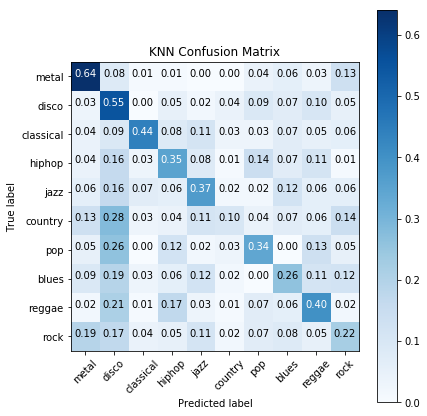

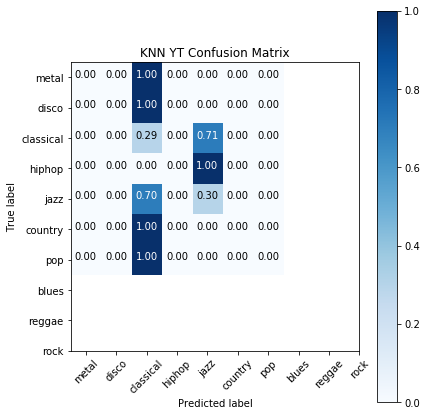

In [128]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_shuffledData):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train,y_train)
    
    actual.extend(y_test)
    guess.extend(knn.predict(X_test))

    yt_guess.extend(knn.predict(yt_data))
    yt_actual.extend(yt_class)

coeff = confusion_matrix(actual, guess)

plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='KNN Confusion Matrix')
print("KNN Score: ", accuracy_score(actual, guess))

coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='KNN YT Confusion Matrix')
print("KNN Youtube Score: ", accuracy_score(yt_guess, yt_actual))

### SVM

SVM Score:  0.44
SVM Youtube Score:  0.2222222222222222
CPU times: user 11.1 s, sys: 294 ms, total: 11.4 s
Wall time: 11.1 s


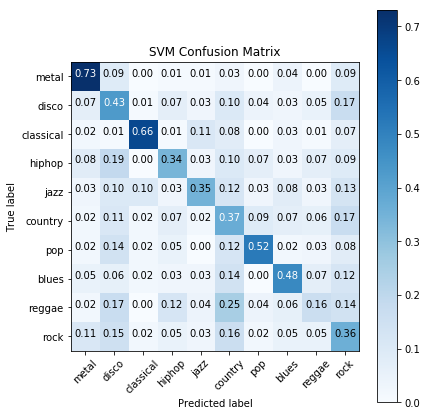

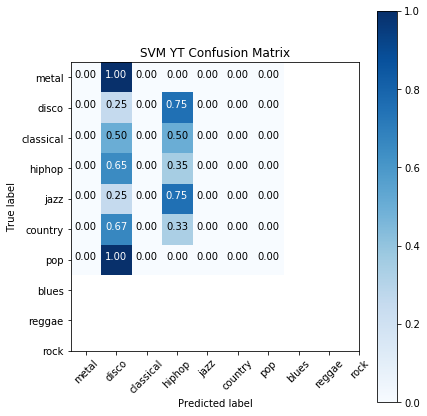

In [129]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_shuffledData):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    svm1 = svm.LinearSVC(C=10, loss='squared_hinge', penalty='l2', tol=0.00001)
    svm1.fit(X_train,y_train)
    
    actual.extend(y_test)
    guess.extend(svm1.predict(X_test))

    yt_guess.extend(svm1.predict(yt_data))
    yt_actual.extend(yt_class)

coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='SVM Confusion Matrix')
print("SVM Score: ", accuracy_score(actual, guess))

coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='SVM YT Confusion Matrix')
print("SVM Youtube Score: ", accuracy_score(yt_guess, yt_actual))

### Decision Tree

Decision Tree Score:  0.397
Decision Youtube Score:  0.3111111111111111
CPU times: user 975 ms, sys: 248 ms, total: 1.22 s
Wall time: 891 ms


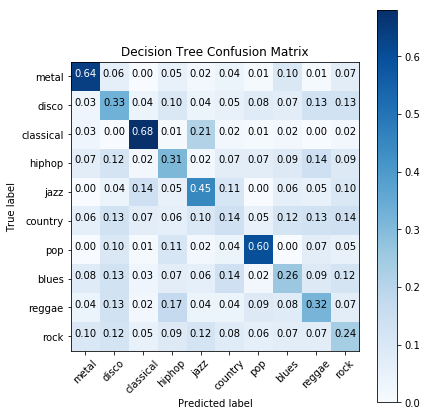

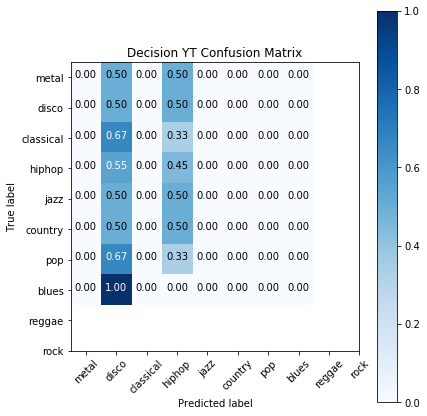

In [130]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_data):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    
    actual.extend(y_test)
    guess.extend(dt.predict(X_test))
    
    yt_guess.extend(dt.predict(yt_data))
    yt_actual.extend(yt_class)
    
coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='Decision Tree Confusion Matrix')        
print("Decision Tree Score: ", accuracy_score(actual, guess))

coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='Decision YT Confusion Matrix')
print("Decision Youtube Score: ", accuracy_score(yt_guess, yt_actual))


### XGBoost

In [ ]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_data):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    xgb_params = {
        'eta': 0.05,
        'max_depth': 5,
        'subsample': 0.9,
        'objective': 'multi:softmax',
        'silent': 1,
        'colsample_bytree': 0.9,
        'num_class':10
    }

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_test, y_test)
    
    model = xgb.train(xgb_params, d_train, num_boost_round = 240)
    
    actual.extend(y_test)
    guess.extend(model.predict(d_valid))
    
    d_yt = xgb.DMatrix(yt_data, yt_class)
    yt_guess.extend(model.predict(d_yt))
    yt_actual.extend(yt_class)
    
coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='XGBoost Confusion Matrix')
print('XGBoost Accuracy Score:',accuracy_score(actual, guess))

coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='XGBoost YT Confusion Matrix')
print("XGBoost Youtube Score: ", accuracy_score(yt_guess, yt_actual))

In [ ]:
# run garbage collector manually
gc.collect()